<a href="https://colab.research.google.com/github/siddharthchd/Tensorflow_Developer/blob/main/lessons/transfer_learning_catsvdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape : {}'.format(last_layer.output_shape))
last_output = last_layer.output

--2020-11-11 01:28:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  98.7MB/s    in 0.8s    

2020-11-11 01:28:31 (98.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0             

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')            # Directory with training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')            # Directory with training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # Directory with validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # Directory with validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1. / 255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Validation data should not be augmented
test_datagen = ImageDataGenerator(rescale = 1. / 255.)

# Flow training images in batche of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        batch_size = 20, 
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

--2020-11-11 01:43:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   147MB/s    in 0.4s    

2020-11-11 01:43:07 (147 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 20, 
                    validation_steps = 50, 
                    verbose = 2)

Epoch 1/20
100/100 - 160s - loss: 0.3684 - accuracy: 0.8640 - val_loss: 0.2826 - val_accuracy: 0.9060
Epoch 2/20
100/100 - 163s - loss: 0.2302 - accuracy: 0.9110 - val_loss: 0.1690 - val_accuracy: 0.9460
Epoch 3/20
100/100 - 161s - loss: 0.2007 - accuracy: 0.9295 - val_loss: 0.2211 - val_accuracy: 0.9380
Epoch 4/20
100/100 - 162s - loss: 0.1852 - accuracy: 0.9235 - val_loss: 0.1071 - val_accuracy: 0.9660
Epoch 5/20
100/100 - 160s - loss: 0.1885 - accuracy: 0.9410 - val_loss: 0.1086 - val_accuracy: 0.9670
Epoch 6/20
100/100 - 155s - loss: 0.1730 - accuracy: 0.9365 - val_loss: 0.0929 - val_accuracy: 0.9680
Epoch 7/20
100/100 - 160s - loss: 0.1796 - accuracy: 0.9375 - val_loss: 0.1277 - val_accuracy: 0.9650
Epoch 8/20
100/100 - 158s - loss: 0.1751 - accuracy: 0.9385 - val_loss: 0.1136 - val_accuracy: 0.9650
Epoch 9/20
100/100 - 152s - loss: 0.1475 - accuracy: 0.9460 - val_loss: 0.1329 - val_accuracy: 0.9590
Epoch 10/20
100/100 - 156s - loss: 0.1652 - accuracy: 0.9450 - val_loss: 0.1399 - 

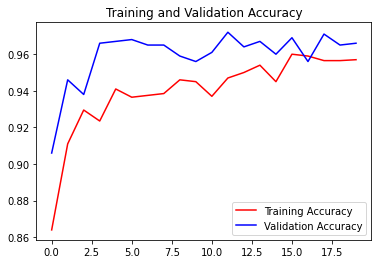

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 0)
plt.figure()
plt.show()